# CTC based ASR

Credits to https://github.com/markovka17/apdl/blob/master/week02/


В этом семинаре обучим модель распознавания речи.

    - Препроцессинг данных
    - Зададим простую модель
    - Обучим модель с CTC лоссом
    - Измерим качество используя метрику CER

In [1]:
from IPython import display
from matplotlib import pyplot as plt
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio
from torchaudio.transforms import MelSpectrogram

import os

import pandas as pd
import numpy as np

Вспомогательная функция для визуализации аудио

In [ ]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    if wav.dim() == 2:
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr))

## Data

Это датасет чисел 0 to 999_999, произнесенных на русском языке.
В датасете спикеры разного пола и возраста.

In [ ]:
!wget https://raw.githubusercontent.com/markovka17/apdl/master/gfile.py
!rm -rf data
!wget wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P" -O numbers.zip && rm -rf /tmp/cookies.txt
!unzip numbers.zip

Конвертируем все данные к одинаковому sample_rate=16000, и преобразуем ответы к определенному виду. Например, если произнесено число 123, то ответом будет: y = [1,2,3].

Для этого создадим класс `SpeechDataset`.

**Задание**: Напишите функцию конвертации чисел в список тензор цифр

In [ ]:
def number2digits(number: np.ndarray) -> torch.Tensor:
    # your code here
    return torch.LongTensor(digits)

In [7]:
number = 157105

assert [1, 5, 7, 1, 0, 5] == number2digits(number)

In [ ]:
class SpeechDataset(Dataset):

    SAMPLE_RATE = 16000
    _ROOT_PREFIX = 'numbers'

    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]

        # находим путь к аудио и конвертируем число
        if len(output) == 3:
            path, gender, number = output
            y = number2digits(number)
        else:
            path, = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        # чтение аудио файла и ресемплинг
        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)

        wav = wav.squeeze()

        instance = {
            'path': path,
            'x': wav,
            'y': y
        }

        return instance

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
dataset = SpeechDataset('numbers/train.csv')

In [ ]:
dataset.csv

,path,gender,number
0,train/e332b996d3.wav,female,157105
1,train/e25afda49a.wav,female,374554
2,train/364f147340.wav,male,688694
3,train/5e0954b206.wav,female,265381
4,train/7130a67690.wav,male,955415
...,...,...,...
8995,train/fec2a3a985.wav,female,782676
8996,train/4d1f90238e.wav,female,783657
8997,train/d5b0591f61.wav,female,40896
8998,train/316347743d.wav,male,852938


Случайно разобъем датасет на `train` и `validation`.

In [ ]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
random_indexes = torch.randperm(len(dataset)).tolist()

train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

len(train_dataset), len(val_dataset)

(8100, 900)

Посмотрим на пример

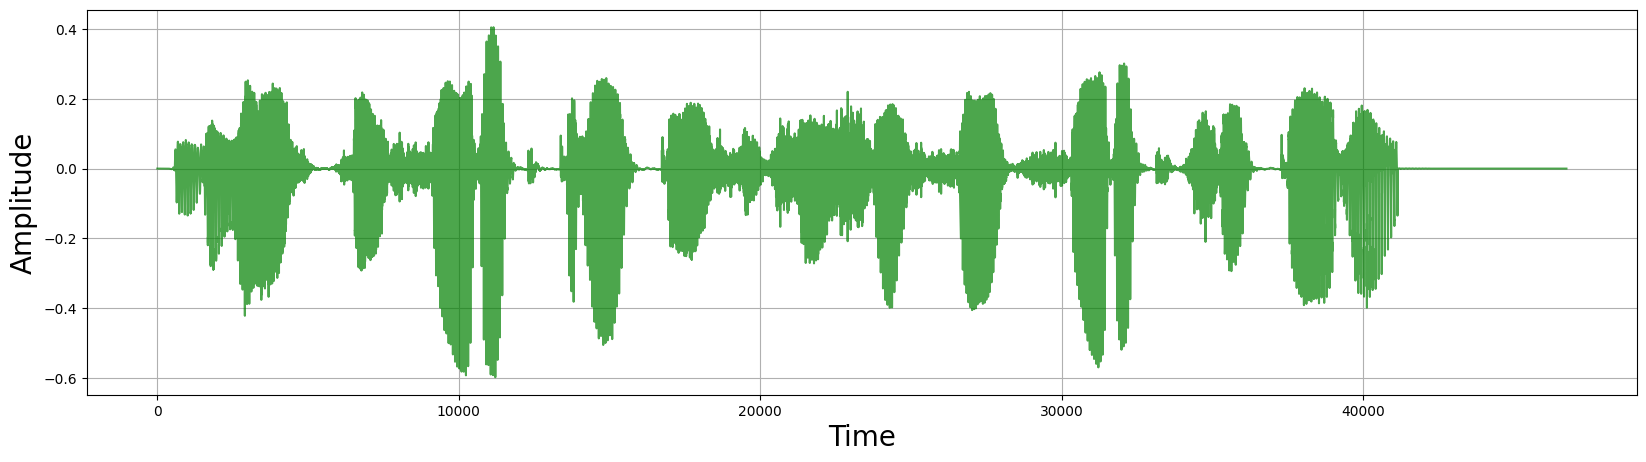

In [ ]:
instance = train_dataset[0]
visualize_audio(instance['x'], dataset.SAMPLE_RATE)

In [ ]:
instance['y']

tensor([2, 4, 3, 6, 4, 4])

Так как датасет состоит из чисел от 0 до 999999, таргеты имеют разную длину. Зададим паддинг, чтобы все ответы имели одинаковую длину.  Если ответ имеет меньше 6 цифр, заполним недостаующие до 6 ячейки '10':

    123456 -> y = [1, 2, 3, 4, 5, 6]

    123    -> y = [1, 2, 3, 10, 10, 10]

In [ ]:
from tqdm import tqdm
from itertools import islice


class PaddingCollator:

    def __call__(self, instances):

        batch_size = len(instances)

        # Собираем длины инпутов и таргетов и пути
        x_len = torch.LongTensor([instance['x'].size(0) for instance in instances])
        y_len = torch.LongTensor([instance['y'].size(0) for instance in instances])
        path = [instance['path'] for instance in instances]

        # Инпут паддим нулями, а таргет -- 10
        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- padding

        for i, instance in enumerate(instances):
            x[i, :x_len[i]] = instance['x']
            y[i, :y_len[i]] = instance['y']

        instance = {
            'x': x,
            'y': y,
            'x_len': x_len,
            'y_len': y_len,
            'path': path
        }

        return instance

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    collate_fn=PaddingCollator(),
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    collate_fn=PaddingCollator(),
    shuffle=False,
)

Посмотрим, что получилось в батче

In [ ]:
batch = list(islice(val_dataloader, 1))[0]
batch['x'][:2, :]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
batch['y'][:2, :]

tensor([[9, 4, 2, 9, 5, 8],
        [1, 3, 4, 7, 2, 5]])

In [ ]:
batch.keys()

dict_keys(['x', 'y', 'x_len', 'y_len', 'path'])

## Feature Extraction

Как и в прошлый раз, обучаться будем на мел спектрограммах

In [ ]:
def apply_compression(melspec):
    # Add eps=1e-7 to avoid log(0)
    return torch.log(melspec.clamp(1e-5))

In [ ]:
class Featurizer(nn.Module):

    def __init__(self):
        super().__init__()

        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            power=1
        )

    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)

        # Convert the length from wav dimension to spectrogram dimension
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len

        return x

## Посчитаем CER (character error rate)

In [ ]:
!pip install Levenshtein

In [ ]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    """
    Decode hypotheses
        1) Remove repetitive letters
        2) Remove blank characters
    """

    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = ''.join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    """
    Calculate the Levenshtein distance between predictions and GT
    """

    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        if decoding == "":
            decoding = "_"

        pairs.append(
            target + '\t\t' + decoding
        )

    return cer / len(target), pairs

## Model

Напишем небольшую модель, основанную на блоках модели QuartzNet https://arxiv.org/pdf/1910.10261.pdf

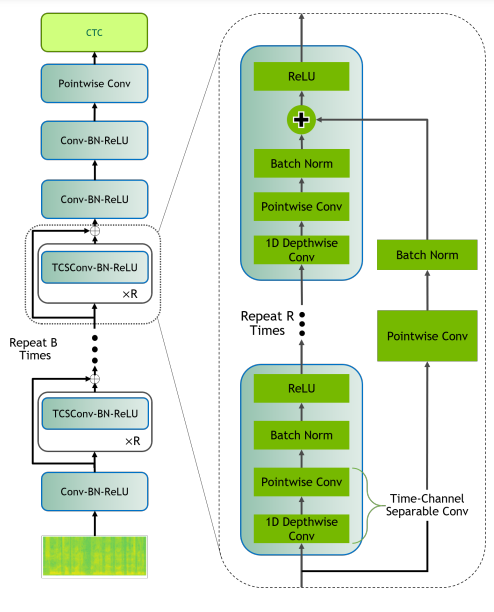

In [ ]:
from torch import nn


class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times

    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 4,
    ):
        super().__init__()

        self.repeat = repeat
        self.blocks = nn.ModuleList([
            nn.ModuleList([
                nn.Conv1d(
                    in_channels=in_channels if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    groups=in_channels if i == 0 else hidden_channels,
                    padding=kernel_size // 2
                ),
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
            ])
            for i in range(repeat)
        ])
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x):
        x_initial = x

        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j ==( len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x

In [ ]:
class DummyModel(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.prenet = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 33, padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )

        self.net = nn.Sequential(
            QuartzBlock(hidden_channels, hidden_channels),
            QuartzBlock(hidden_channels, hidden_channels * 2),

            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, 33,
                      padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),

            QuartzBlock(hidden_channels * 2, hidden_channels * 4)
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x, x_len):
        x = self.prenet(x)
        x = self.net(x)

        if x_len is not None:
            return self.classifier(x), x_len // 4
        else:
            return self.classifier(x)

## Training

In [ ]:
class AverageMeter:

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DummyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:
history = defaultdict(list)

In [ ]:
for epoch in range(NUM_EPOCH):

    average_cer_train = AverageMeter()
    average_loss_train = AverageMeter()
    average_cer_test = AverageMeter()
    average_loss_test = AverageMeter()

    model.train()
    for batch in train_dataloader:
        x = batch['x'].to(DEVICE)
        y = batch['y'].to(DEVICE)
        x_len = batch['x_len'].to(DEVICE)
        y_len = batch['y_len'].to(DEVICE)

        x, x_len = mel_featurizer(x, x_len)

        log_probs, x_len = model(x, x_len)

        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer_train.update(cer)
        average_loss_train.update(loss.item())

        history['loss_train'].append(average_loss_train.avg)
        history['cer_train'].append(average_cer_train.avg)

    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            x = batch['x'].to(DEVICE)
            y = batch['y'].to(DEVICE)
            x_len = batch['x_len'].to(DEVICE)
            y_len = batch['y_len'].to(DEVICE)

            x, x_len = mel_featurizer(x, x_len)

            log_probs, x_len = model(x, x_len)

            # B, C, T -> T, B, C
            log_probs = log_probs.permute(2, 0, 1)
            loss = criterion(log_probs, y, x_len, y_len)

            # T, B, C -> T, B -> B, T
            argmax_decoding = log_probs.detach().cpu().argmax(dim=-1).transpose(0, 1)

            cer, pairs = calculate_cer(y, argmax_decoding)

            average_cer_test.update(cer)
            average_loss_test.update(loss.item())

        history['loss_test'].append(average_loss_test.avg)
        history['cer_test'].append(average_cer_test.avg)

    display.clear_output()
    print(f'Epoch: {epoch}')
    for i in range(min(5, len(pairs))):
        print(f'Example of prediction: ', pairs[i].replace("\t\t", " -> "))

    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    for ax, subset in zip(axes, ["train", "test"]):
        ax[0].plot(history[f'loss_{subset}'], label=f'Loss {subset}')
        ax[1].plot(history[f'cer_{subset}'], label=f'CER {subset}')
        for a in ax:
            a.legend(); a.grid()
    plt.show()

## Inference

In [ ]:
def inference(wav, sr):
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        wav = resampler(wav)

    model.eval()
    with torch.no_grad():
        x = wav.unsqueeze(0).to(DEVICE)
        x = mel_featurizer(x)
        log_probs = model(x)

        # B, C, T -> B, T
        argmax_decoding = log_probs.detach().cpu().argmax(dim=1)

        print(f"Prediction: {''.join([str(i.item()) for i in argmax_decoding[0]])}")
        visualize_audio(wav, 16000)

In [ ]:
batch = next(iter(val_dataloader))

In [ ]:
inference(batch["x"][0], sr=val_dataset.SAMPLE_RATE)

**Задание**: Проверьте инференс модели на своей записи (пример, как записать свой голос есть в тетрадке предыдущего семинара)

## Домашнее задание



    1) Добавьте аугментации (см. предыдущую тетрадку)
    2) Измените предсказание по argmax на beam search (см. предыдущую тетрадку)
    3) Добавить специальный символ между цифрами, определяющий порядок (тысячи, сотни)
    4) *Переведите числа в слова и обучите модель распознавать слова (здесь можно добавить метрику WER)